In [1]:
import os
import copy
import sys 

# Regular Modules
import numpy as np
import sklearn as sklearn
import matplotlib.pyplot as plt
import datetime
import scipy.integrate as scint
#from numpy.random import default_rng
import numpy.ma as ma
import matplotlib.tri as tri
import scipy.io
import time 
from mpl_toolkits.mplot3d import axes3d

# parallelization modules 
from math import nan
from joblib import Parallel, delayed
import multiprocessing
import itertools

# # My Modules
import model_systems, helpers, potentials, diffusion_map 
from fem.distmesh import * 
from fem.FEM_TPT import *
import sampling 

# Set up the problem 

In [2]:
# first choose problem 
problem = "muller"
datadir = "/Users/shashanksule/Documents/TMDmaps/data/Muller/ground_data/DistmeshMueller_20.mat"
if problem == "muller":
    system = potentials.Muller(1/20, datadir) 
elif problem == "twowell":
    system = potentials.Twowell(1, datadir)
else:
    print("invalid problem")

In [3]:
# next choose dataset params 

dataset = "metadynamics"
x0 = np.array([0,0])
dt = 1e-4
Vbdry = 10 # 10 for muller, 1 (or less for twowell)

# metadynamics params here
Nbumps = int(1e3) 
Ndeposit = int(1e3)
subsample = int(1e2)
height = 5*np.ones(Nbumps)
sig = 0.05 

In [4]:
# compute dataset 

if dataset == "gibbs": 
    data = sampling.euler_maruyama_OLD(system.drift, system.target_beta, \
                                       dt, x0, \
                                       int(1e6), int(1e2))
elif dataset == "metadynamics":
    data = sampling.euler_maruyama_metadynamics_OLD(system.drift, system.target_beta, \
                                                    dt, x0, height, sig, \
                                                    Ndeposit, Nbumps, subsample)
elif dataset == "uniform": 
    data = sampling.fem_pts(system, 0.05, Vbdry)

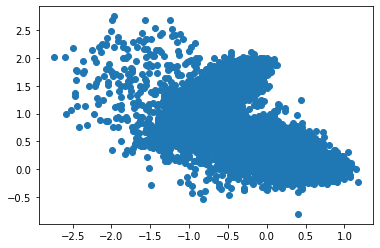

In [5]:
# visualize dataset 

plt.scatter(data[:,0], data[:,1])

In [6]:
# upload fem soltuon
system.load_fem()

# Set up t.m. diffusion map 

In [7]:
# tmd map params 
ϵ = 2**(-5) # bandwidth
δ = 0.01 # sparsification 
vbdry = 10 # error comparison region 
n_neigh = 1024 # knn-neigbours 
σ = 3

In [8]:
# set up diff. map 
δ_net, _ = helpers.epsilon_net(data.T, δ)
data_uniformized = data[δ_net, :] 
err_boolz = system.throwing_pts_muller(data_uniformized.T, vbdry)
N = data_uniformized.shape[0] 

In [9]:
# compute t.m.
target_measure = np.zeros(N)
for i in range(N):
    target_measure[i] = system.density(data_uniformized[i,:])

In [10]:
# get tmdmap 
target_dmap = diffusion_map.TargetMeasureDiffusionMap(epsilon=ϵ, n_neigh=n_neigh, target_measure=target_measure)

In [11]:
# get kernel and generator 

target_dmap.construct_generator(data_uniformized.T)
K = target_dmap.get_kernel()
L = target_dmap.get_generator() 

In [12]:
q_tmd = target_dmap.construct_committor(L, err_boolz['B_bool'], err_boolz['C_bool'])

# Compare errors 

In [13]:
# checking interpolation, run this only if you want
q_interpolant_fem_to_tmd = scipy.interpolate.griddata(system.qfem['pts'], system.qfem['committor'], data_uniformized, \
                                                    method='linear')
q_interpolant_tmd_to_fem = scipy.interpolate.griddata(data_uniformized, q_tmd, system.qfem['pts'], \
                                                  method='linear')

In [14]:
fem_error_boolz = system.throwing_pts_muller(system.qfem['pts'].T, vbdry)

In [15]:
# compute errors on fem points 
q_fem_error = system.qfem['committor'][fem_error_boolz['error_bool']]
q_interpolant_tmd_to_fem_error = q_interpolant_tmd_to_fem[fem_error_boolz['error_bool']].reshape(q_fem_error.shape)

# compute errors on tmd points 
q_tmd_error = q_tmd[err_boolz['error_bool']]
q_interpolant_fem_to_tmd_error = q_interpolant_fem_to_tmd[err_boolz['error_bool']].reshape(q_tmd_error.shape)


In [18]:
helpers.RMSerror(q_fem_error, q_interpolant_tmd_to_fem_error, checknans=True)

TypeError: RMSerror() got an unexpected keyword argument 'checknans'

# Eigenvalue 

In [ ]:
ϵ = 2**(-5) # bandwidth
δ = 0.01 # sparsification 
vbdry = 10 # error comparison region 
n_neigh = 1024 # knn-neigbours  
target_dmap = diffusion_map.TargetMeasureDiffusionMap(epsilon=ϵ, n_neigh=n_neigh, target_measure=target_measure)
evals = np.zeros(100) 

for i in range(100): 
    data = sampling.euler_maruyama_metadynamics_OLD(system.drift, system.target_beta, \
                                                    dt, x0, height, sig, \
                                                    Ndeposit, Nbumps, int(1e4))
    target_dmap.construct_generator(data_uniformized.T)
    K = target_dmap.get_kernel()
    L = target_dmap.get_generator() 
    